In [1]:
import pandas as pd
import numpy as np
import sys
import os
sys.path.append('..')

import warnings
import matplotlib.pyplot as plt
import plotly.express as px
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import mean_squared_error

In [2]:
import os
pathdata = './../../../datasets/'
pathresults = 'results'
if not os.path.exists(pathresults):
    os.makedirs(pathresults)

In [3]:
# Función para predecir el valor del DSR en las especies de lenteja en el futuro.

def predict_future(regressor, scaler, df_future, models):

    predictions_future = {}   
    
    # Voy guardando los índices para, después de entrenar todos los modelos, quedarme con el valor medio
    future_index = df_future.index.values

    # Del total del dataset voy seleccionando la bio_1 (temperatura media anual) y la bio_12 (precipitacion) de cada uno de los modelos
    for m in models:
        futuro_model = df_future[['DECLONGITUDE','DECLATITUDE',m, m+'_B12', 'srad_12', 'srad_annual', 't_bulk_dens', 't_sand', 't_soilwater_cap', 't_teb']]
        futuro_model = futuro_model.rename(columns={m: 'CURRENT_BIO1', m+'B12': 'CURRENT_BIO12'})

        futuro_test_pred_scaled = scaler.transform(futuro_model)

        # Todas las predicciones las voy guardando en un diccionario en el que la clave es el nombre del modelo_escenario
        predictions_future[m] = regressor.predict(futuro_test_pred_scaled)

    return future_index, predictions_future


In [4]:
# Función para predecir el valor del DSR en las especies de lenteja silvestres en el presente.

def silvestres_predict_present(regressor, scaler, df_present):
        
    # Voy guardando los índices para, después de entrenar todos los modelos, quedarme con el valor medio
    silvestres_present_index = df_present.index.values
    
    lentejas_silvestres_scaled = scaler.transform(df_present)
    predictions_silvestres_presente = regressor.predict(lentejas_silvestres_scaled)

    return silvestres_present_index, predictions_silvestres_presente

## MODELOS Y ESCENARIO A EVALUAR

In [5]:
models = ['BCC_126', 'BCC_370', 'BCC_585', 'CNRM_126', 'CNRM_370','CNRM_585', 'IPSL_126', 'IPSL_370', 'IPSL_585']

## **LENTEJAS EVALUADAS POR SU RESISTENCIA A LA ROYA**

## Load Data Lentejas Roya: Temperatura y Precipitación

In [6]:
roya_raw = pd.read_csv(pathdata+"DatosPrecip/ROYA_Completa_fut_pres.txt",decimal=',',sep= '\t')

# Me quedo solo con las columnas de latitud, longitud, predicciones de bio_1 y bio_12 para el presente y el futuro
cols_to_drop = list(roya_raw.columns[0:5]) + list(roya_raw.columns[[7, 8, 9, 10]])
roya_raw = roya_raw.drop(cols_to_drop, axis = 1)

# Renombro y transformo a float las columnas para mantener el mismo formato en todos los datasets
roya_raw = roya_raw.rename(columns={'Longitude': 'DECLONGITUDE', 'Latitude': 'DECLATITUDE'})
roya_raw = roya_raw.applymap(lambda x: float(x))

roya_raw[['BBC_126', 'BBC_370', 'BBC_585', 'CNRM_126', 'CNRM_370','CNRM_585', 'IPSL_126', 'IPSL_370', 'IPSL_585']] = roya_raw[['BBC_126', 'BBC_370', 'BBC_585', 'CNRM_126', 'CNRM_370','CNRM_585', 'IPSL_126', 'IPSL_370', 'IPSL_585']].applymap(lambda x: x*10)
roya_raw.drop_duplicates(inplace = True)

roya_raw.head(1)

,DECLATITUDE,DECLONGITUDE,BBC_126,BBC_370,BBC_585,CNRM_126,CNRM_370,CNRM_585,IPSL_126,IPSL_370,...,BCC_370_B12,BCC_585_B12,IPSL_126_B12,IPSL_370_B12,IPSL_585_B12,CNRM_126_B12,CNRM_370_B12,CNRM_585_B12,CURRENT_BIO1,CURRENT_BIO12
0,37.491944,-2.773611,152.875004,155.166664,157.624998,154.458332,153.374996,154.958334,155.333328,155.749998,...,402.0,389.0,375.0,377.0,366.0,393.0,386.0,380.0,142.839996,443.359985


In [7]:
print(roya_raw.shape)

(247, 22)


## Load Data Lentejas Roya: radiación, condiciones del suelo y DSR

In [8]:
# Cargamos el dataset con todas las variables de radiación, condiciones del suelo, DSR y coordenadas para las lentejas
# evaluadas por su resistencia la roya en el presente.

roya = pd.read_csv(pathdata+"DatosPresente/fichtraining_ROYA_CAMPO_nondup.csv",decimal=',',sep=';',)
roya = roya[['srad_12', 'srad_annual', 't_bulk_dens', 't_sand', 't_soilwater_cap', 't_teb', 'DECLONGITUDE','DECLATITUDE','ROYA_CAMPO_AVERAGE_DSR']]

roya.head(1)

,srad_12,srad_annual,t_bulk_dens,t_sand,t_soilwater_cap,t_teb,DECLONGITUDE,DECLATITUDE,ROYA_CAMPO_AVERAGE_DSR
0,5194,14868.75,1451.699951,37.0,23.700001,28.799999,5.133333,43.916667,0.0


In [9]:
print(roya.shape)

(255, 9)


## Dataset Lentejas Roya Presente

In [10]:
# Unimos las condiciones de radiación y el suelo, con el valor de temperatura y precipitación para el presente.

roya_presente = pd.merge(roya_raw[['DECLONGITUDE','DECLATITUDE','CURRENT_BIO1', 'CURRENT_BIO12']],roya, how='inner', on = ['DECLONGITUDE','DECLATITUDE'])
roya_presente.drop_duplicates(subset = ['DECLONGITUDE','DECLATITUDE'], inplace = True)
roya_presente.head()

,DECLONGITUDE,DECLATITUDE,CURRENT_BIO1,CURRENT_BIO12,srad_12,srad_annual,t_bulk_dens,t_sand,t_soilwater_cap,t_teb,ROYA_CAMPO_AVERAGE_DSR
0,-2.773611,37.491944,142.839996,443.359985,7587,17020.333984,1501.800049,34.000000,21.549999,19.799999,58.293233
1,-5.270000,37.786944,178.600006,605.280029,7271,16987.083984,1526.949951,36.880001,22.775000,23.476000,61.787905
2,-17.758611,28.797222,191.125000,370.312500,10670,18398.333984,1358.599976,47.000000,26.575001,10.000000,70.940348
3,-3.956667,37.768889,165.479996,563.799988,7406,16711.083984,1518.650024,33.959999,23.549999,26.976000,77.256578
4,-4.855556,42.221667,116.400002,489.720001,4885,14776.583008,1515.974976,19.000000,21.000000,46.599998,72.408651


In [11]:
print(roya_presente.shape)

(247, 11)


# LENTEJAS SILVESTRES

## Dataset Lentejas Silvestres Presente

In [12]:
lentejas_silvestres = pd.read_excel(pathdata+"DatosPresente/SupplementaryTable3_RubioTeso_etal_Martonne_bio12.xlsx")

# Renombro y transformo las columnas (la temperatura se debe multiplicar por 10 para estar en el mismo orden) para 
# mantener el mismo formato en todos los datasets
lentejas_silvestres = lentejas_silvestres.rename(columns={'Longitude_decimal': 'DECLONGITUDE', 'Latitude_decimal': 'DECLATITUDE', 'bio_12' : 'CURRENT_BIO12'})
lentejas_silvestres['CURRENT_BIO1'] = lentejas_silvestres.bio_1.apply(lambda x: x*10)
lentejas_silvestres.drop('bio_1', axis = 1, inplace = True)

lentejas_silvestres = lentejas_silvestres[['DECLONGITUDE','DECLATITUDE','CURRENT_BIO1','CURRENT_BIO12','srad_12', 'srad_annual', 't_bulk_dens', 't_sand', 't_soilwater_cap','t_teb']]
lentejas_silvestres.drop_duplicates(subset = ['DECLONGITUDE','DECLATITUDE'], inplace = True)
lentejas_silvestres.dropna(inplace = True)

lentejas_silvestres.head()

,DECLONGITUDE,DECLATITUDE,CURRENT_BIO1,CURRENT_BIO12,srad_12,srad_annual,t_bulk_dens,t_sand,t_soilwater_cap,t_teb
0,22.502781,38.523891,99.448338,800.0,0.5364,14913.33301,1422.625000,28.0,23.950001,37.599998
1,33.700000,44.650000,107.978334,496.0,0.5352,13129.16699,1484.375000,21.0,23.825001,22.900000
2,33.716667,44.483333,94.020004,571.0,0.5124,13137.33301,1451.250000,23.0,24.150000,22.100000
3,34.582500,41.724720,80.598335,676.0,0.4556,14525.75000,1402.900024,38.0,23.650000,27.100000
4,37.200000,37.100000,140.310001,580.0,0.5284,17900.00000,1502.800049,26.0,24.900000,13.400000


In [13]:
lentejas_silvestres.shape

(613, 10)

## Dataset Lentejas Silvestres Futuro

In [14]:
silv_futuro = pd.read_csv(pathdata+"DatosPrecip/Len_silvestres_futuro_B1_B12.txt",decimal=',',sep= '\t')

# Me quedo sólo con las columnas relativas a las predicciones de bio_1 y bio_12 de los escenarios futuros
silv_futuro = silv_futuro[['bbc_126', 'bbc_370', 'bbc_585',
       'CNRM_126', 'CNRM_370', 'CNRM_585', 'IPSL_126', 'IPSL_370', 'IPSL_585',
       'BBC_126_B12', 'BBC_370_B12', 'BBC_585_B12', 'IPSL_126_B12',
       'IPSL_370_B12', 'IPSL_585_B12', 'CNRM_126_B12', 'CNRM_370_B12',
       'CNRM_585_B12',"DECLATITUD", "DECLONGITU"]]

# Renombro y transformo a float columnas para mantener el mismo formato en todos los datasets
silv_futuro = silv_futuro.rename(columns={'DECLONGITU': 'DECLONGITUDE', 'DECLATITUD': 'DECLATITUDE','bbc_126': 'BCC_126', 'bbc_370': 'BCC_370', 'bbc_585': 'BCC_585','BBC_126_B12':'BCC_126_B12', 'BBC_370_B12':'BCC_370_B12', 'BBC_585_B12':'BCC_585_B12'})
silv_futuro = silv_futuro.applymap(lambda x: float(x))

# La temperatura se debe multiplicar por 10 para estar en el mismo orden en todos los datasets. Descarto posibles duplicados
# en cuanto a las coordenadas y valores nulos
silv_futuro[models] = silv_futuro[models].applymap(lambda x: x * 10)
silv_futuro.drop_duplicates(subset = ['DECLONGITUDE','DECLATITUDE'], inplace = True)
silv_futuro.dropna(inplace = True)

# Para poder disponer de las condiciones de radiación, suelo... Extraigo esos valores del dataset de lentejas silvestres
# en el presente mediante el merge
silvest_futuro = pd.merge(silv_futuro,lentejas_silvestres, how='inner', on = ['DECLONGITUDE','DECLATITUDE'])
silvest_futuro.head()

,BCC_126,BCC_370,BCC_585,CNRM_126,CNRM_370,CNRM_585,IPSL_126,IPSL_370,IPSL_585,BCC_126_B12,...,DECLATITUDE,DECLONGITUDE,CURRENT_BIO1,CURRENT_BIO12,srad_12,srad_annual,t_bulk_dens,t_sand,t_soilwater_cap,t_teb
0,119.000006,117.958336,119.875002,115.958338,114.624996,118.333330,115.958328,116.833334,113.458338,584.0,...,44.404167,33.825000,108.059521,562.0,0.554286,12971.75000,1420.675049,0.0,24.950001,0.0
1,179.874992,181.124992,182.500000,181.333332,179.791660,182.666664,181.333332,182.124996,180.708332,657.0,...,40.063611,18.466389,167.154770,658.0,0.920000,15401.50000,1487.474976,27.0,22.875000,13.4
2,147.125006,148.083334,150.249996,149.375000,147.458334,150.375004,148.291664,148.958330,147.791662,703.0,...,38.083300,28.200000,143.915005,688.0,0.636400,17663.41602,1498.675049,80.0,22.325001,10.4
3,161.875000,163.708324,165.541668,163.541660,162.124996,164.624996,163.541660,164.291668,162.666664,584.0,...,40.600000,17.150000,149.216671,584.0,0.838800,15037.66699,1488.724976,42.0,24.775000,14.0
4,126.250000,128.750000,131.875000,127.791672,126.000004,128.874998,127.458334,129.250002,126.416664,1082.0,...,45.500000,15.570600,110.120001,1041.0,0.548800,12406.50000,1445.849976,79.0,23.600000,11.0


In [15]:
silvest_futuro.shape

(603, 28)

## MODEL TRAIN

In [16]:
warnings.filterwarnings("ignore")

index_roya_present = np.array([])
pred_values_roya_present = np.array([])


index_silvestes_present = np.array([])
silvestres_values_present = np.array([])

index_silvestes_future = np.array([])
results_silvestre_future_models = pd.Series([])

importances_rf = {}
for col in list(roya_presente):
    if col!= 'ROYA_CAMPO_AVERAGE_DSR':
        importances_rf[col] = []

error_values_rf = []        

nexper = 500
for i in range(0, nexper):

    # Para realizar la predicción, descartamos la variable objetivo (ROYA_CAMPO_AVERAGE_DSR)
    variables_to_ignore = ['ROYA_CAMPO_AVERAGE_DSR']
    selected_features = [element for element in list(roya_presente) if element not in variables_to_ignore]
    
    df_model = roya_presente[selected_features]
    
    std_scaler = StandardScaler()
    
    std_scaler_model = std_scaler.fit(df_model)
    df_model = std_scaler_model.transform(df_model)
    
    
    "Division Train Test"
    
    X = pd.DataFrame(data = df_model, columns = selected_features)
    y = roya_presente.ROYA_CAMPO_AVERAGE_DSR

    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size= 0.7)

    #Vamos a iterar el modelo 500 veces para quedarnos con el valor del DSR medio en cada predicción. Vamos concatenando en un array los índices que se han seleccionado para la matriz de test
    index_roya_present = np.concatenate((index_roya_present, roya_presente.iloc[X_test.index.values].index.values), axis=None)

    # Hacemos el entrenamiento del modelo con las lentejas evaluadas por su resistencia a la roya en el presente
    "Random Forest"
    clf = RandomForestRegressor()
    clf.fit(X_train, y_train)
    predictions_roya_presente = clf.predict(X_test)
    pred_values_roya_present = np.concatenate((pred_values_roya_present, predictions_roya_presente), axis=None)
    
    # Me quedo con la importancia de cada una de las variables para todas las iteraciones del modelo
    for k in range(0, len(selected_features)):
        importances_rf[selected_features[k]].append(clf.feature_importances_[k])
    
    
    rmse_rf = np.sqrt(mean_squared_error(y_test, predictions_roya_presente))

    error_values_rf.append(rmse_rf)
    
    
##############################################################################################################################
############################################ PREDICT SILVESTRES PRESENT ######################################################
##############################################################################################################################

    # Llamamos a la función para predecir el DSR de las lentejas silvestres en el presente
    silvestres_present_index, results_silvestres_present = silvestres_predict_present(clf, std_scaler_model, lentejas_silvestres)
    
    # Voy almacenando en una lista todos los índices y las predicciones que me va devolviendo la función
    index_silvestes_present = np.concatenate((index_silvestes_present, silvestres_present_index), axis=None)
    silvestres_values_present = np.concatenate((silvestres_values_present, results_silvestres_present), axis=None)
    
##############################################################################################################################
############################################ PREDICT SILVESTRES FUTURE #######################################################
##############################################################################################################################
    
    results_silvestre_future_models_concat = pd.Series([])
    
    # Llamamos a la función para predecir el DSR de las lentejas en el futuro. El procedimiento es el mismo
    # que para el caso de las lentejas evaluadas por su resistencia a la roya
    silvestre_future_index, results_silvestres_futuro = predict_future(clf, std_scaler_model, silvest_futuro, models)
    index_silvestes_future = np.concatenate((index_silvestes_future, silvestre_future_index), axis=None)

    for m in models:
        results_silvestre_future_models_concat = pd.concat([results_silvestre_future_models_concat, pd.Series(results_silvestres_futuro[m])], axis = 1)
    
    results_silvestre_future_models_concat.columns = ['to_drop'] + models
    results_silvestre_future_models_concat.drop('to_drop', axis = 1, inplace = True)

    results_silvestre_future_models = pd.concat([results_silvestre_future_models, results_silvestre_future_models_concat])

## RMSE RF

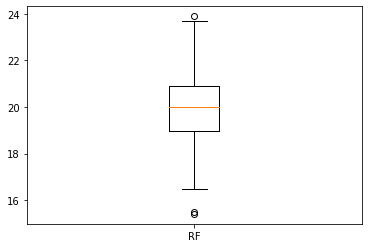

RF RMSE mean 19.969592683766233


In [17]:
arr = [error_values_rf]
box = plt.boxplot(arr,labels=['RF'])
plt.show()

print("RF RMSE mean",np.mean(error_values_rf))

## Feature Importance

In [18]:
importances_rf_avg = {}

for k,v in importances_rf.items():
    importances_rf_avg[str(k)] = np.mean(v)

{k: v for k, v in sorted(importances_rf_avg.items(), key=lambda item: item[1])}

{'srad_12': 0.04506353091390063,
 'DECLATITUDE': 0.055139084670583975,
 'srad_annual': 0.06145917028499171,
 't_teb': 0.06544818331027474,
 't_sand': 0.07023038485215534,
 'CURRENT_BIO1': 0.07191565087818606,
 't_soilwater_cap': 0.08880912663917996,
 't_bulk_dens': 0.0927046056532044,
 'CURRENT_BIO12': 0.16173952478449338,
 'DECLONGITUDE': 0.28749073801302977}

In [19]:
df = pd.DataFrame(data=importances_rf)
df = (df.T)
df.to_excel(pathresults+"/feature_importances_RF.xlsx", index=False)

## Resultados Data Lenteja Roya Presente

In [20]:
# Generamos un DF con los resultados para cada una de las iteraciones
results_roya_present = pd.concat([pd.Series(index_roya_present), pd.Series(pred_values_roya_present)], axis = 1)
results_roya_present.columns = ['test_index', 'DSR_prediction']
results_roya_present.head()

# Con el objetivo de conocer a qué especies corresponden, asociamos el índice con las coordenadas correspondientes
results_roya_present_loc = pd.merge(results_roya_present, roya_presente[['DECLATITUDE','DECLONGITUDE']].reset_index(), how = 'left', left_on=['test_index'],right_on=['index'])
results_roya_present_loc.to_excel(pathresults+"/Roya_Presente_all_iter_RF.xlsx", index=False)

In [21]:
# Calculamos la mediana de cada una de las predicciones para conocer el DSR promedio
avg_results_roya_present = results_roya_present.groupby('test_index').median()
avg_results_roya_present.head()

# Con el objetivo de conocer a qué especies corresponden, asociamos el índice con las coordenadas correspondientes
results_roya_presente_loc = avg_results_roya_present.join(roya_presente[['DECLATITUDE','DECLONGITUDE','ROYA_CAMPO_AVERAGE_DSR']])
results_roya_presente_loc.to_excel(pathresults+"/Roya_Presente_avg_RF.xlsx", index=False)
results_roya_presente_loc.head()

,DSR_prediction,DECLATITUDE,DECLONGITUDE,ROYA_CAMPO_AVERAGE_DSR
test_index,,,,
0.0,66.273860,37.491944,-2.773611,58.293233
1.0,54.923753,37.786944,-5.270000,61.787905
2.0,54.713250,28.797222,-17.758611,70.940348
3.0,52.317291,37.768889,-3.956667,77.256578
4.0,60.124230,42.221667,-4.855556,72.408651


## Resultados Lentejas Silvestres Presente

In [22]:
results_present_silvestres = pd.concat([pd.Series(index_silvestes_present), pd.Series(silvestres_values_present)], axis = 1)
results_present_silvestres.columns = ['test_index', 'DSR_prediction']

results_present_silvestres_loc = pd.merge(results_present_silvestres, lentejas_silvestres[['DECLATITUDE','DECLONGITUDE']].reset_index(), how = 'left', left_on=['test_index'],right_on=['index'])
results_present_silvestres_loc.to_excel(pathresults+"/Silvestres_Presente_alliter_RF.xlsx", index=False)



In [23]:
avg_present_silvestres = results_present_silvestres.groupby('test_index').median()
avg_present_silvestres.head()

results_silv_present_loc = avg_present_silvestres.join(lentejas_silvestres[['DECLATITUDE','DECLONGITUDE']])
results_silv_present_loc.to_excel(pathresults+"/Silvestres_Presente_avg_RF.xlsx", index=False)
results_silv_present_loc.sort_values(by = 'DSR_prediction').head()

,DSR_prediction,DECLATITUDE,DECLONGITUDE
test_index,,,
481.0,20.604547,43.81977,5.29961
494.0,21.624523,43.90419,5.55207
482.0,21.890218,43.99968,5.30687
123.0,22.105769,39.53056,19.91028
487.0,22.106904,43.82001,5.37558


In [25]:
# Por congruencia con el artículo anterior y porque resulta una selección que optimiza el resultado, me parece coherente seleccionar las poblaciones que para las condiciones ambientales presentes se estimen valores de DSr inferiores a los obtenidos en el primer decil del training set (DSr=25?).
# 
thr = results_silv_present_loc[results_silv_present_loc.DSR_prediction < results_silv_present_loc.DSR_prediction.quantile(.10)].sort_values(by=['DSR_prediction'], ascending = False).iloc[0]['DSR_prediction']
print(thr)

27.17051435209647


In [26]:
results_silv_present_loc[results_silv_present_loc.DSR_prediction < thr].sort_values(by = ['DSR_prediction'])

,DSR_prediction,DECLATITUDE,DECLONGITUDE
test_index,,,
481.0,19.895422,43.819770,5.299610
494.0,21.312307,43.904190,5.552070
482.0,21.579916,43.999680,5.306870
487.0,21.747750,43.820010,5.375580
495.0,22.200519,43.994140,5.556100
...,...,...,...
333.0,26.908223,40.030830,22.173889
136.0,26.913763,39.301941,21.114441
568.0,26.950074,44.019230,7.554830


{'whiskers': [<matplotlib.lines.Line2D at 0x131838ee790>,
 'caps': [<matplotlib.lines.Line2D at 0x131838eeeb0>,
 'boxes': [<matplotlib.lines.Line2D at 0x131838ee400>],
 'medians': [<matplotlib.lines.Line2D at 0x131838de610>],
 'fliers': [<matplotlib.lines.Line2D at 0x131838de9a0>],
 'means': []}

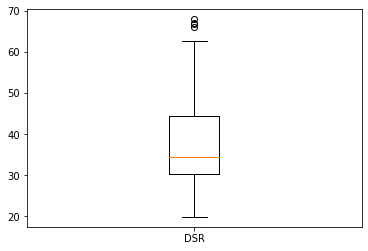

In [27]:
plt.boxplot(results_silv_present_loc['DSR_prediction'], labels=['DSR'])

## Resultados Lentejas Silvestres Futuro

In [26]:
results_silvestre_future_models.drop(0, axis = 1, inplace = True)
results_silvestre_future_models['test_index'] = index_silvestes_future
results_silvestre_future_models.head()

results_silvestre_future_models_loc = pd.merge(results_silvestre_future_models, silvest_futuro[['DECLATITUDE','DECLONGITUDE']].reset_index(), how = 'left', left_on=['test_index'],right_on=['index'])
results_silvestre_future_models_loc.to_excel(pathresults+"/Silvestres_Future_alliter_RF.xlsx", index=False)

In [27]:
avg_future_results_silvestre = results_silvestre_future_models.groupby('test_index').median()
avg_future_results_silvestre.head()

results_silv_future_loc = avg_future_results_silvestre.join(results_silv_present_loc)
results_silv_future_loc.to_excel(pathresults+"/Silvestres_Future_avg_RF.xlsx", index=False)
results_silv_future_loc.head()

,BCC_126,BCC_370,BCC_585,CNRM_126,CNRM_370,CNRM_585,IPSL_126,IPSL_370,IPSL_585,DSR_prediction,DECLATITUDE,DECLONGITUDE
test_index,,,,,,,,,,,,
0.0,43.918099,43.858055,43.851933,43.863005,44.269437,44.003787,43.824717,43.978213,44.358057,33.878540,38.523891,22.502781
1.0,41.218971,40.825937,41.441139,41.396653,41.396653,41.214520,41.270621,41.404446,41.422954,43.183892,44.650000,33.700000
2.0,29.606680,29.155607,29.595356,29.242893,29.030822,29.045612,29.505514,29.876548,30.575811,44.154872,44.483333,33.716667
3.0,30.315733,29.729751,29.997243,30.247990,29.748478,30.155217,30.235927,29.826592,30.345764,36.386059,41.724720,34.582500
4.0,28.887071,28.547151,28.195135,28.554802,28.756100,28.463928,28.577588,28.448742,28.663374,35.442285,37.100000,37.200000


In [45]:
thr_futuro = thr * 1.1
print(thr_futuro)

resist = results_silv_future_loc[(results_silv_future_loc.DSR_prediction < thr_futuro)]

for col in models:
    resist = resist[resist[col] < thr_futuro]

print(resist.shape)
resist.head()

29.73759778246257
(33, 12)


,BCC_126,BCC_370,BCC_585,CNRM_126,CNRM_370,CNRM_585,IPSL_126,IPSL_370,IPSL_585,DSR_prediction,DECLATITUDE,DECLONGITUDE
test_index,,,,,,,,,,,,
8.0,28.152733,28.148148,27.215480,27.142271,27.142271,27.967907,28.128596,27.967907,28.022329,28.531963,38.500000,27.283300
12.0,23.092322,22.807991,23.088764,23.012965,23.073491,22.946070,23.183274,23.167155,23.121869,29.119026,38.984718,21.660561
77.0,20.480106,21.021591,20.962640,20.885089,20.610980,20.900522,20.709436,20.995842,20.552594,23.477184,36.300000,30.133300
89.0,25.542835,25.686671,25.556975,25.584040,25.865885,25.527283,25.801580,25.584040,25.612482,28.258004,34.905280,33.091110
91.0,29.004136,28.731938,29.004136,28.995435,29.257499,28.993788,27.645777,29.004136,27.677589,29.501855,34.892500,33.112500


In [46]:
red_natura = pd.read_excel(pathdata+"DatosPresente/LentejasSilvestresAreasProtegidas.xlsx")[['ORIGCTY','DECLATITUD','DECLONGITU']]
red_natura = red_natura.rename(columns={'DECLONGITU': 'DECLONGITUDE', 'DECLATITUD': 'DECLATITUDE'})
red_natura.head()

,ORIGCTY,DECLATITUDE,DECLONGITUDE
0,GRC,38.523891,22.502781
1,UKR,44.483333,33.716667
2,ESP,39.823900,2.883060
3,GRC,38.984718,21.660561
4,GRC,37.866667,21.883333


In [47]:
pd.merge(resist,red_natura, how='inner', on = ['DECLONGITUDE','DECLATITUDE'])

,BCC_126,BCC_370,BCC_585,CNRM_126,CNRM_370,CNRM_585,IPSL_126,IPSL_370,IPSL_585,DSR_prediction,DECLATITUDE,DECLONGITUDE,ORIGCTY
0,23.092322,22.807991,23.088764,23.012965,23.073491,22.946070,23.183274,23.167155,23.121869,29.119026,38.984718,21.660561,GRC
1,25.542835,25.686671,25.556975,25.584040,25.865885,25.527283,25.801580,25.584040,25.612482,28.258004,34.905280,33.091110,CYP
2,29.004136,28.731938,29.004136,28.995435,29.257499,28.993788,27.645777,29.004136,27.677589,29.501855,34.892500,33.112500,CYP
3,26.822709,27.557986,28.151307,27.533057,27.053045,27.667861,27.203502,27.614018,27.133904,24.817757,43.448610,16.712220,HRV
4,20.353872,20.438742,23.345400,20.419513,20.389466,20.419513,22.458763,20.087224,22.560943,29.322878,38.478611,22.685280,GRC
5,27.358313,27.592044,27.664593,27.497266,27.420185,27.558075,27.766738,27.766738,27.669432,24.293407,43.912270,5.178800,FRA
6,26.885503,27.408439,26.523320,26.536146,26.904845,26.492504,26.665548,26.589193,26.920521,22.301488,43.994140,5.556100,FRA
7,23.731084,23.578678,23.514493,23.689620,23.624568,23.529395,23.618468,23.490635,23.742663,24.444482,44.003670,5.568060,FRA
